## Data literacy

Machine Learning in Science, University of Tübingen, Winter Semester 2022


Applying the concepts of *entropy* and *information* to create a bot that can play [Wordle](https://www.nytimes.com/games/wordle/index.html).

Wordle is a word game created by Josh Wardle and published by The New York Times. In the game, one has six attempts to guess the five-letter daily word. During each attempt one has to propose a valid five-letter word. After proposing a word you will receive feedback in the form of a pattern of colored tiles. Green indicates a matching letter, yellow indicates a match - but in the wrong spot, and grey indicates that the guessed letter is not in the daily word. For example:

you guessed: TABOO

⬛⬛🟩⬛⬛

B is in the daily word and in the correct spot.


You guessed: QUACK

⬛🟨⬛⬛⬛

U is in the daily word but in a different spot.

This project is inspired by [3Blue1Brown's video](https://youtu.be/v68zYyaEmEA). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import os
import math

### Loading the data

The *wordle_reduced_dataset.txt* file contains a subset of the words used in the actual game, so that the code runs quickly.

In [3]:
file = 'wordle_reduced_dataset.txt'

def load_data(file):
    """
    Loads a .txt file to a list
    """
    with open(file) as f:
        word_list = [ word.splitlines()[0] for word in f.readlines() ]
    return word_list

word_list = load_data(file)
print(word_list)

['aback', 'acrid', 'afoot', 'alarm', 'alone', 'ample', 'anvil', 'armor', 'attic', 'awoke', 'barge', 'beady', 'belly', 'billy', 'blaze', 'blond', 'bonus', 'bowel', 'breed', 'brook', 'bully', 'cabin', 'canon', 'cease', 'chasm', 'china', 'cinch', 'cleft', 'clown', 'conch', 'covet', 'crazy', 'crime', 'crump', 'cynic', 'debut', 'dense', 'dingy', 'donor', 'drape', 'drool', 'dusty', 'eclat', 'elite', 'enter', 'ethic', 'extol', 'fault', 'fetid', 'filmy', 'flame', 'flood', 'flyer', 'forum', 'fritz', 'furor', 'gawky', 'girth', 'glory', 'goose', 'grate', 'groin', 'guest', 'hairy', 'haven', 'heron', 'horse', 'hurry', 'igloo', 'inlet', 'jerky', 'junto', 'knelt', 'lapse', 'learn', 'lever', 'llama', 'lousy', 'lusty', 'mambo', 'mason', 'melee', 'mince', 'molar', 'mound', 'murky', 'neigh', 'noise', 'occur', 'onset', 'ovary', 'panic', 'patty', 'perky', 'pinch', 'plait', 'plush', 'pound', 'prism', 'pubic', 'quack', 'quiet', 'raise', 'razor', 'refit', 'resin', 'rinse', 'roger', 'ruder', 'salty', 'savvy', 

### What is the initial entropy?

The definition of entropy $H(X)$ for a discrete random variable $X$ is the expected amount of information content: $\mathbb{E}[I(X)]$. Here, the information content $I(X)$ is defined as : $I(X) = \log_2\left(\frac{1}{p(X)}\right)$.

**Calculating the initial entropy using this dataset**. Assumption: each word in the dataset to be equaly likely to be the daily word.

In [17]:
entropy_word_list = len(word_list) * (-1) * math.log(1/len(word_list),2) * 1/len(word_list)
print(entropy_word_list)

7.266786540694903


### Reducing the entropy
This wordle bot will try to make guesses that reduce the entropy as much as possible. We will do this by calculating the expected information gain for each possible word in our dataset and subsequently pick the best candidate word.


When we propose a 5 letter word in the wordle game, we receive a pattern (e.g.: ⬛🟩⬛🟩⬛, or ⬛🟨🟩⬛⬛). 

**How many possible patterns are there?**

In [18]:
n_patterns = 3**5
print(n_patterns)

243


We will associate each pattern with an index ranging from *0* to *n_patterns-1*. If you want to know what the pattern for a given index looks like you can call the *patterns_to_string* function()

In [19]:
pattern_index = 30
print(patterns_to_string([pattern_index]))

⬛🟨⬛🟨⬛


After proposing a word and receiving a pattern of colored tiles, we can reduce the size of our dataset - we can simply discard all the words that are not consistent with this pattern / word combination! 

However we do not know what pattern we receive before proposing a word. What we can however calculate, is the probability of receiving each possible pattern (given that we have a list of possible words). We can then use this to calculate the expected information (entropy) gain for the proposed word.

We included the function *get_pattern_distributions()* that given a (list of) proposed word(s) and a list all the possible words, returns how often each pattern occurs. We included an example call using the word 'ethic'

**Assume our proposed word is 'ethic'. Create a bar plot with the x axis as the pattern indices and the y axis as the number of occurrences of each pattern. Do you see any structure? Explain why this arises.**

243


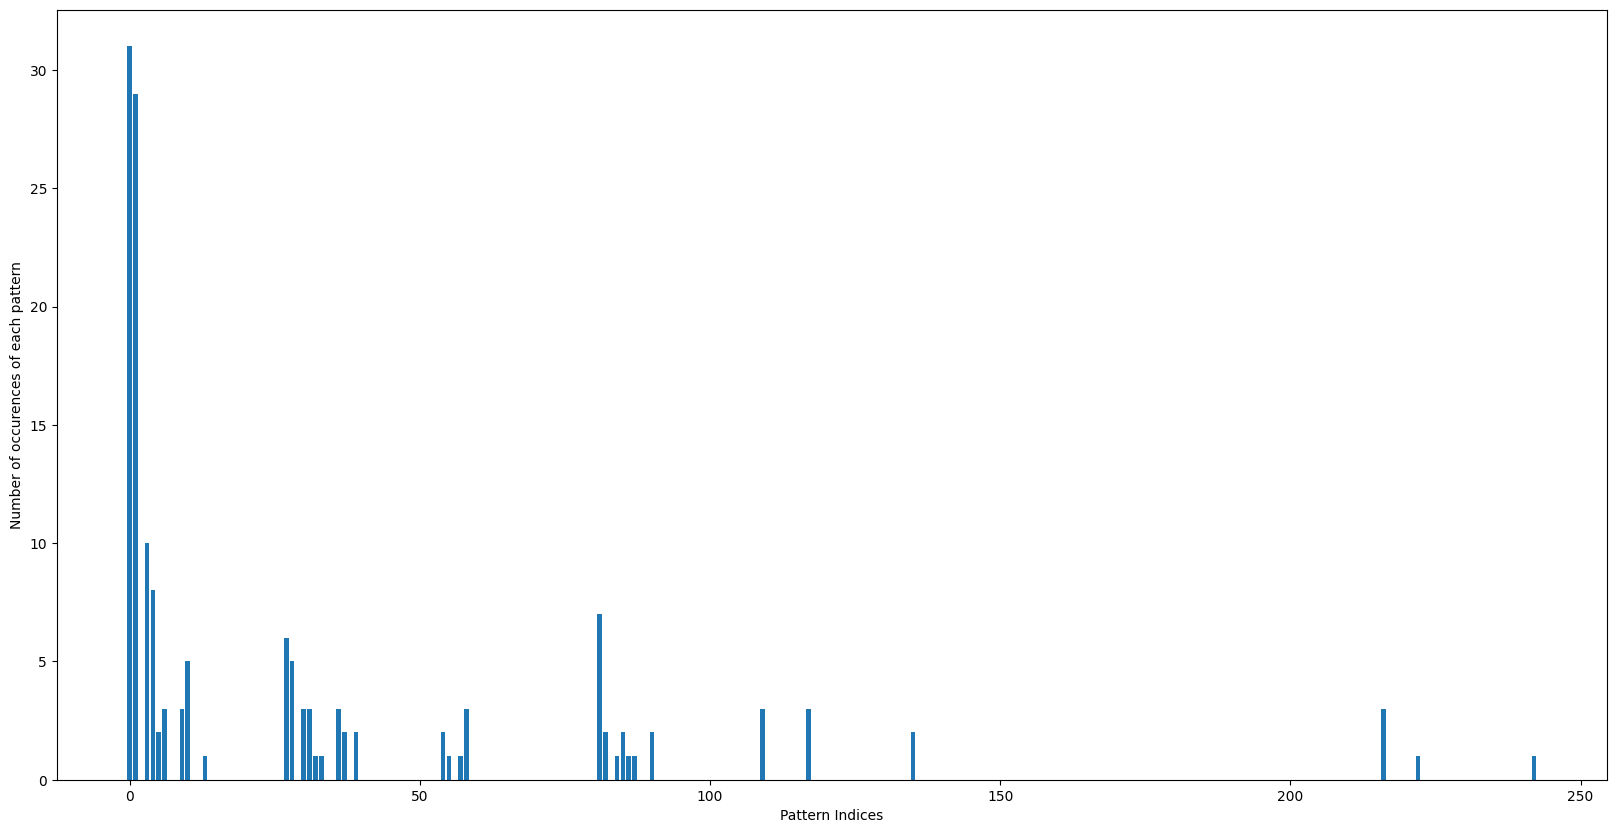

In [28]:
pattern_dist_ethic = get_pattern_distributions(['ethic'], word_list)[0]
print(len(pattern_dist_ethic))
plt.figure(figsize = (20, 10))
plt.bar(np.arange(0, len(pattern_dist_ethic)), pattern_dist_ethic)
plt.xlabel("Pattern Indices")
plt.ylabel("Number of occurences of each pattern")
plt.show()

# The structure can be explained by the fact that different patterns occur in cluster of the different combinations of their own. So as soon as the pattern 
# changes drastically, a new structure begins to form. Hence different cluster form on the grand scale.

**Use the pattern distribution above to calculate the expected information gain for the word 'ethic'.** Note that there are quite some patterns that occur with zero probability. To handle numerical errors in the computation of entropy, assume that $-p(x)\log(p(x)) = 0$ when $p(x) = 0$.

In [21]:
def entropy(patterns_dist):
    """
    Calculates the expected information given a distribution of patterns
    """
    entropy = 0
    for i in patterns_dist:
        if i != 0:
            entropy += -1 * i/len(patterns_dist) * math.log(i/len(patterns_dist))
    return entropy

entropy_ethic = entropy(pattern_dist_ethic)
print(entropy_ethic)


2.143809477104211


### Creating the wordle bot

Now we are ready to create a bot that can play wordle! **Complete the best_pick() function**. Your bot can call any of the functions we previously used.

In [22]:
class Wordle_bot():
    
    def __init__(self, word_list):
        """
        Initialize a Wordle bot
        
        Args:
            word_list: list of words that can be used in the wordle game
        """
        
        # stores all words in our dataset
        self.initial_word_list = word_list.copy()
        
        # keeps track of all currently allowed words
        # this list should get shorter as the game progresses
        self.allowed_word_list = word_list.copy() 
    
    def reset(self):
        """
        Resets the bot, all words in the dataset are possible again
        """
        
        self.allowed_word_list = self.initial_word_list.copy()
    
    def initialize_for_next_round(self, allowed_word_list):
        """
        Sets the allowed word list, use after making a guess
        
        Args:
            allowed_word_list: list of words that are still possible answers
        """
        
        self.allowed_word_list = allowed_word_list.copy()
        
        
    def best_pick(self):
        """
        Picks the word with the highest expected information gain.
        
        Returns:
            best_word: string, word with highest expected information
            
        """
        best_entropy_yet = 0
        best_word = ""
        for a_word in self.allowed_word_list:
            pd_a_word = get_pattern_distributions([a_word], self.allowed_word_list)[0]
            entropy_a_word = entropy(pd_a_word)
            if entropy_a_word > best_entropy_yet:
                best_entropy_yet = entropy_a_word
                best_word = a_word
        return best_word

**Initialize a bot and find out what is the best word to start a game with** (for this dataset)

In [23]:
bot = Wordle_bot(word_list)
print(bot.best_pick())

raise


### Play a single round

**Complete the code below to allow your bot to play a single round of the game** 

In [24]:
bot.reset() # reset the bot before playing a round
answer = word_list[np.random.randint(len(word_list))] # pick a random daily word

round_n=1
guesses=[]
score=0
possibility_counts=[]
patterns = []
guess = ""
while guess != answer and round_n <6:
    guess = bot.best_pick()
    pattern = get_pattern(guess, answer)
    possibilities = get_possible_words(guess, pattern, bot.allowed_word_list)
    bot.initialize_for_next_round(possibilities)

    patterns.append(pattern)
    guesses.append(guess)    
    possibility_counts.append(len(possibilities))
    score += 1
    round_n+=1

print("\n".join([
    "",
    f"Score: {score}",
    f"Answer: {answer}",
    f"Guesses: {guesses}",
    f"Reductions: {possibility_counts}",
    *patterns_to_string((*patterns, 3**5 - 1)).split("\n"),
    *" " * (6 - len(patterns)),
    *" " * 2,
]))



Score: 3
Answer: igloo
Guesses: ['raise', 'billy', 'igloo']
Reductions: [8, 1, 1]
⬛⬛🟨⬛⬛
⬛🟨🟩⬛⬛
🟩🟩🟩🟩🟩
🟩🟩🟩🟩🟩
 
 
 
 
 


### Play all the rounds

Once you are confident the bot is working properly, you can use it to play through all possible rounds. **How many attempts does it need to get the right word, on average?** 

In [25]:
final_result=simulate_games(bot, word_list,quiet=True)
print(final_result)

{'score_distribution': [1, 61, 86, 6], 'total_guesses': 405, 'average_score': 2.6298701298701297, 'game_results': [{'score': 2, 'answer': 'aback', 'guesses': ['raise'], 'patterns': [3], 'reductions': [4]}, {'score': 2, 'answer': 'acrid', 'guesses': ['raise'], 'patterns': [13], 'reductions': [2]}, {'score': 3, 'answer': 'afoot', 'guesses': ['raise', 'aback'], 'patterns': [3, 2], 'reductions': [4, 1]}, {'score': 2, 'answer': 'alarm', 'guesses': ['raise'], 'patterns': [4], 'reductions': [6]}, {'score': 3, 'answer': 'alone', 'guesses': ['raise', 'ample'], 'patterns': [165, 191], 'reductions': [5, 1]}, {'score': 2, 'answer': 'ample', 'guesses': ['raise'], 'patterns': [165], 'reductions': [5]}, {'score': 2, 'answer': 'anvil', 'guesses': ['raise'], 'patterns': [12], 'reductions': [4]}, {'score': 3, 'answer': 'armor', 'guesses': ['raise', 'alarm'], 'patterns': [4, 110], 'reductions': [6, 1]}, {'score': 3, 'answer': 'attic', 'guesses': ['raise', 'anvil'], 'patterns': [12, 56], 'reductions': [4,

In [27]:
# your code here
# Attempts needed on average to get the correct answer
print(final_result['average_score'])

2.6298701298701297
